<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/SellBuyHoldPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment

In [0]:
%tensorflow_version 1.x
!pip install ta
!pip uninstall pandas-datareader
!pip install pandas-datareader

## Import Libraray

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn

import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import datetime as dt
import os
from operator import itemgetter

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader.data  as pdr
from tqdm.auto import tqdm
from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *
from pandas.plotting import register_matplotlib_converters

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from sklearn.utils.class_weight import compute_class_weight

register_matplotlib_converters()
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]


## Parameters

In [0]:
training_days = 20
total_years = 20
total_dates = total_years * 365
training_itmes = (int)(total_years * 252 * 0.7)
intervals = range(6, 27)  # 21

In [0]:
ticker = 'IBM' #@param ["GOOG", "IBM", "MSFT", "AAPL"]
data = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())

## Technical Indicators

In [0]:
def calculate_RSI(data, intervals):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )
    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """
    print("Caclulation RSI")
    for i in tqdm(intervals):
        delta = data['Close'] - data['Close'].shift(1)
        gain = (delta > 0) * delta
        loss = (delta < 0) * -delta
        avg_gain = gain.rolling(i).sum() / i
        avg_loss = loss.rolling(i).sum() / i
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        data['rsi_' + str(i)] = rsi

def calcualte_IBR(data):
    return (data['Close'] - data['Low']) / (data['High'] - data['Low'])

def calculate_WilliamR(data, intervals):
    """
    Momentum indicator
    Using TA Libraray
    %R = (Highest High - Close)/(Highest High - Lowest Low) * -100
    """
    print("Caclulation WilliamR")
    for i in tqdm(intervals):
        data['wr_' + str(i)] = wr(data['High'], data['Low'], data['Close'], i, fillna=True)

def calculate_MFI(df, intervals):
    """
    Momentum type indicator
    """
    print("Caclulation MFI")
    for i in tqdm(intervals):
        df['mfi_' + str(i)] = money_flow_index(data['High'], data['Low'], data['Close'], data['Volume'], n=i, fillna=True)

def calculate_roc(series, period):
    return ((series.iloc[-1] - series.iloc[0]) / series.iloc[0]) * 100

def calculate_ROC(data, intervals):
    """
    Momentum oscillator
    As per implement https://www.investopedia.com/terms/p/pricerateofchange.asp
    https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
    ROC = (close_price_n - close_price_(n-1) )/close_price_(n-1) * 100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    print("Caclulation ROC")
    for period in tqdm(intervals):
        data['roc_' + str(period)] = np.nan
        # for 12 day period, 13th day price - 1st day price
        res = data['Close'].rolling(period + 1).apply(calculate_roc, args=(period,), raw=False)
        data['roc_' + str(period)] = res

def calculate_CMF(data, intervals):
    """
    An oscillator type indicator & volume type
    No other implementation found
    """
    print("Caclulation CMF")
    for i in tqdm(intervals):
        data['cmf_' + str(i)] = chaikin_money_flow(data['High'], data['Low'], data['Close'], data['Volume'], i, fillna=True)

def calculate_cmo(series, period):
    # num_gains = (series >= 0).sum()
    # num_losses = (series < 0).sum()
    sum_gains = series[series >= 0].sum()
    sum_losses = np.abs(series[series < 0].sum())
    cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
    return np.round(cmo, 3)

def calculate_CMO(data, intervals):
    """
    Chande Momentum Oscillator
    As per https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
    CMO = 100 * ((Sum(ups) - Sum(downs))/ ( (Sum(ups) + Sum(downs) ) )
    range = +100 to -100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    diff = data["Close"].diff()[1:]  # skip na
    print("Caclulation CMO")
    for period in tqdm(intervals):
        data['cmo_' + str(period)] = np.nan
        res = diff.rolling(period).apply(calculate_cmo, args=(period,), raw=False)
        data['cmo_' + str(period)][1:] = res

def calculate_SMA(data, intervals, col_name = 'Close'):
    """
    Momentum indicator
    """
    print("Calculating SMA " + col_name)
    for i in tqdm(intervals):
        data[col_name + '_sma_' + str(i)] = data[col_name].rolling(i).mean()

def calculate_EMA(data, intervals):
    """
    Momentum indicator
    """
    print("Calculating EMA")
    for i in tqdm(intervals):
        data['ema_' + str(i)] = data['Close'].ewm(span=i, min_periods=i-1).mean()

def wavg(rolling_prices, period):
    weights = pd.Series(range(1, period + 1))
    return np.multiply(rolling_prices.values, weights.values).sum() / weights.sum()

def calculate_WMA(data, intervals, hma_step=0):
    """
    Momentum indicator
    """
    if (hma_step == 0):
        print("Calculating WMA")

    temp_col_count_dict = {}
    for i in tqdm(intervals, disable=(hma_step != 0)):
        res = data['Close'].rolling(i).apply(wavg, args=(i,), raw=False)
        # print("interval {} has unique values {}".format(i, res.unique()))
        if hma_step == 0:
            data['wma_' + str(i)] = res
        elif hma_step == 1:
            if 'hma_wma_' + str(i) in temp_col_count_dict.keys():
                temp_col_count_dict['hma_wma_' + str(i)] = temp_col_count_dict['hma_wma_' + str(i)] + 1
            else:
                temp_col_count_dict['hma_wma_' + str(i)] = 0
                # after halving the periods and rounding, there may be two intervals with same value e.g.
                # 2.6 & 2.8 both would lead to same value (3) after rounding. So save as diff columns
                df['hma_wma_' + str(i) + '_' + str(temp_col_count_dict['hma_wma_' + str(i)])] = 2 * res
        elif hma_step == 3:
            import re
            expr = r"^hma_[0-9]{1}"
            columns = list(df.columns)
            # print("searching", expr, "in", columns, "res=", list(filter(re.compile(expr).search, columns)))
            data['hma_' + str(len(list(filter(re.compile(expr).search, columns))))] = res

def calculate_TRIX(data, intervals):
    """
    Shows the percent rate of change of a triple exponentially smoothed moving average.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:trix
    TA lib actually calculates percent rate of change of a triple exponentially
    smoothed moving average not Triple EMA.
    Momentum indicator
    Need validation!
    """
    print("Caclulation TRIX")
    for i in tqdm(intervals):
        data['trix_' + str(i)] = trix(data['Close'], i, fillna=True)

def calculate_CCI(data, intervals):
    """
    Commodity Channel Index (CCI)
    CCI measures the difference between a security’s price change and its average 
    price change. High positive readings indicate that prices are well above their 
    average, which is a show of strength. Low negative readings indicate that 
    prices are well below their average, which is a show of weakness.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
    """
    print("Caclulation CCI")
    for i in tqdm(intervals):
        data['cci_' + str(i)] = cci(data['High'], data['Low'], data['Close'], i, fillna=True)

def calculate_DPO(data, intervals):
    """
    Detrended Price Oscillator (DPO)
    Is an indicator designed to remove trend from price and make it easier to 
    identify cycles.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:detrended_price_osci    
    """
    print("Caclulation DPO")
    for i in tqdm(intervals):
        data['dpo_' + str(i)] = dpo(data['Close'], n=i)

def calculate_KST(data, intervals):
    """
    KST Oscillator (KST Signal)
    It is useful to identify major stock market cycle junctures because its 
    formula is weighed to be more greatly influenced by the longer and more 
    dominant time spans, in order to better reflect the primary swings of stock 
    market cycle.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:know_sure_thing_kst  """
    print("Calculating KST")
    for i in tqdm(intervals):
        data['kst_' + str(i)] = kst(data['Close'], i)

def calculate_DMI(data, intervals):
    """
    Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI) are 
    derived from smoothed averages of these differences, and measure trend direction 
    over time. These two indicators are often referred to collectively as the 
    Directional Movement Indicator (DMI).
    The Average Directional Index (ADX) is in turn derived from the smoothed 
    averages of the difference between +DI and -DI, and measures the strength 
    of the trend (regardless of direction) over time.
    Using these three indicators together, chartists can determine both the 
    direction and strength of the trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx
    """
    print("Calculating DMI")
    for i in tqdm(intervals):
        data['dmi_'+str(i)] = adx(data['High'], data['Low'], data['Close'], n=i, fillna=True)

def calculate_BB_MAV(data, intervals):
    """
    Bollinger Bands (BB)
    N-period simple moving average (MA).
    https://en.wikipedia.org/wiki/Bollinger_Bands
    """
    print("Calculating Bollinger Band MAV")
    for i in tqdm(intervals):
        data['bb_' + str(i)] = bollinger_mavg(data['Close'], n=i, fillna=True)

def calculate_FI(data, intervals):
    """
    Force Index (FI)
    It illustrates how strong the actual buying or selling pressure is. 
    High positive values mean there is a strong rising trend, and low 
    values signify a strong downward trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:force_index
    """
    print("Calculating Force Index")
    for i in tqdm(intervals):
        data['fi_' + str(i)] = force_index(data['Close'], data['Volume'], n=i, fillna=True)

def calculate_EOM(ohlc, ndays=20):
    """
    An Oscillator type indicator and volume type
    Ease of Movement : https://www.investopedia.com/terms/e/easeofmovement.asp
    """
    print("Calculating EOM")
    dm = (data['High'] + data['Low']) / 2 - (data['High'].shift(1) - data['Low'].shift(1)) / 2
    br = data['Volume'] / (data['High'] - data['Low'])
    evm = dm / br
    for i in tqdm(intervals):
        data['eom_' + str(i)] = evm.rolling(i).mean()

In [0]:
def calculate_technical_indicators(data, intervals):
  # Momentum Indicators
  calculate_RSI(data, intervals)
  calculate_WilliamR(data, intervals)
  calculate_MFI(data, intervals)
  
  # calculate_MACD(data, intervals)  # ready to use +3
  # calculate_PPO(data, intervals)  #ready to use +1
  calculate_ROC(data, intervals)  # Took long
  calculate_CMF(data, intervals)  # volume EMA
  calculate_CMO(data, intervals)  # Took long
  calculate_SMA(data, intervals)
  calculate_SMA(data, intervals, 'Open')
  calculate_EMA(data, intervals)
  calculate_WMA(data, intervals)
  """
  calculate_HMA(data, intervals)
  """
  # Trending 
  calculate_TRIX(data, intervals)
  calculate_CCI(data, intervals)
  calculate_DPO(data, intervals)  # Trend oscillator
  calculate_KST(data, intervals)
  calculate_DMI(data, intervals) 
  # volatility
  calculate_BB_MAV(data, intervals)
  # calculate_PSI(data, intervals)  # can't find formula
  calculate_FI(data, intervals)  # volume
  calculate_EOM(data, intervals)


In [27]:
calculate_technical_indicators(data, intervals)
data.dropna(inplace=True)

Caclulation RSI



Caclulation WilliamR



Caclulation MFI



Caclulation ROC



Caclulation CMF



Caclulation CMO



Calculating SMA Close



Calculating SMA Open



Calculating EMA



Calculating WMA



Caclulation TRIX



Caclulation CCI



Caclulation DPO



Calculating KST



Calculating DMI


/usr/local/lib/python3.6/dist-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])



Calculating Bollinger Band MAV



Calculating Force Index



Calculating EOM


In [28]:
display(data)

,High,Low,Open,Close,Volume,Adj Close,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_15,rsi_16,rsi_17,rsi_18,rsi_19,rsi_20,rsi_21,rsi_22,rsi_23,rsi_24,rsi_25,rsi_26,wr_6,wr_7,wr_8,wr_9,wr_10,wr_11,wr_12,wr_13,wr_14,wr_15,wr_16,wr_17,wr_18,...,fi_8,fi_9,fi_10,fi_11,fi_12,fi_13,fi_14,fi_15,fi_16,fi_17,fi_18,fi_19,fi_20,fi_21,fi_22,fi_23,fi_24,fi_25,fi_26,eom_6,eom_7,eom_8,eom_9,eom_10,eom_11,eom_12,eom_13,eom_14,eom_15,eom_16,eom_17,eom_18,eom_19,eom_20,eom_21,eom_22,eom_23,eom_24,eom_25,eom_26
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-04-03,122.375000,119.437500,120.000000,122.000000,7715600.0,79.616753,52.657005,60.800000,62.015504,62.878788,63.703704,66.438356,67.333333,68.987342,66.261398,67.013373,68.820225,64.814815,66.071429,68.181818,68.100358,62.227074,65.191147,66.730769,64.259259,62.635379,59.621993,-55.865922,-47.393365,-37.593985,-37.593985,-37.593985,-34.129693,-30.395137,-30.395137,-28.248588,-28.248588,-24.271845,-24.271845,-24.271845,...,8.201849e+06,8.389560e+06,8.479456e+06,8.476384e+06,8.389889e+06,8.230923e+06,8.010335e+06,7.738205e+06,7.423582e+06,7.074417e+06,6.697606e+06,6.299068e+06,5.883849e+06,5.456226e+06,5.019811e+06,4.577635e+06,4.132238e+06,3.685738e+06,3.239891e+06,0.000062,0.000063,0.000065,0.000061,0.000059,0.000059,0.000058,0.000056,0.000055,0.000054,0.000056,0.000056,0.000056,0.000056,0.000056,0.000058,0.000057,0.000057,0.000056,0.000056,0.000055
2000-04-04,126.937500,115.062500,121.500000,121.187500,16667200.0,79.086540,36.085627,51.053864,59.259259,60.491493,61.367837,62.206148,64.991625,65.905383,67.596899,64.977645,65.743440,67.586207,63.719116,64.993726,67.137809,67.058824,61.356297,64.349553,65.906933,63.494968,61.909010,-48.691099,-53.554502,-53.554502,-42.481203,-42.481203,-42.481203,-38.566553,-34.346505,-34.346505,-31.920904,-31.920904,-27.427184,-27.427184,...,3.369860e+06,4.003228e+06,4.475537e+06,4.806636e+06,5.015737e+06,5.120491e+06,5.136677e+06,5.078167e+06,4.957031e+06,4.783693e+06,4.567111e+06,4.314951e+06,4.033758e+06,3.729106e+06,3.405731e+06,3.067657e+06,2.718291e+06,2.360519e+06,1.996781e+06,0.000070,0.000066,0.000066,0.000067,0.000063,0.000061,0.000061,0.000060,0.000058,0.000057,0.000056,0.000057,0.000057,0.000058,0.000057,0.000057,0.000059,0.000058,0.000058,0.000058,0.000057
2000-04-05,125.750000,119.750000,120.500000,125.000000,8693500.0,81.574562,56.289308,46.134021,57.172131,63.588850,64.576271,65.282392,65.960912,68.237082,68.991098,70.396601,67.896175,68.540830,70.101781,66.385542,67.482517,69.340659,69.264544,63.737374,66.385768,67.773788,65.424610,-16.315789,-16.753927,-24.644550,-24.644550,-19.548872,-19.548872,-19.548872,-17.747440,-15.805471,-15.805471,-14.689266,-14.689266,-12.621359,...,9.986329e+06,9.831376e+06,9.687979e+06,9.529525e+06,9.343157e+06,9.123845e+06,8.870982e+06,8.586392e+06,8.273141e+06,7.934835e+06,7.575201e+06,7.197853e+06,6.806159e+06,6.403184e+06,5.991665e+06,5.574016e+06,5.152345e+06,4.728477e+06,4.303980e+06,0.000071,0.000072,0.000068,0.000068,0.000068,0.000065,0.000063,0.000063,0.000062,0.000060,0.000058,0.000057,0.000059,0.000059,0.000059,0.000058,0.000058,0.000060,0.000059,0.000059,0.000059
2000-04-06,128.000000,122.625000,123.500000,122.750000,8887400.0,80.106194,60.067114,50.564972,42.216981,53.244275,59.836066,60.862620,61.598746,62.307692,64.697406,65.492958,66.981132,64.713542,65.389527,67.031630,63.625866,64.765101,66.701903,66.631468,61.500975,64.221014,65.652174,-40.579710,-40.579710,-40.579710,-41.706161,-41.706161,-33.082707,-33.082707,-33.082707,-30.034130,-26.747720,-26.747720,-24.858757,-24.858757,...,3.323445e+06,3.865771e+06,4.290774e+06,4.608496e+06,4.829341e+06,4.963774e+06,5.021965e+06,5.013512e+06,4.947283e+06,4.831337e+06,4.672901e+06,4.478403e+06,4.253511e+06,4.003199e+06,3.731812e+06,3.443127e+06,3.140426e+06,2.826544e+06,2.503933e+06,0.000073,0.000072,0.000072,0.000068,0.000068,0.000069,0.000065,0.000064,0.000063,0.000062,0.000061,0.000059,0.000058

## Create Label

In [0]:
def create_labels(data, window_size=11):
  """
  Data is labeled as per the logic in research paper
  Label code : BUY => 1, SELL => 0, HOLD => 2
  params :
      df => Dataframe with data
      col_name => name of column which should be used to determine strategy
  returns : numpy array with integer codes for labels with
            size = total-(window_size)+1
  """
  BUY = 1
  SELL = -1
  HOLD = 0
  row_counter = 0
  total_rows = len(data)
  labels = np.zeros(total_rows)
  labels[:] = np.nan
  print("Calculating labels")
  pbar = tqdm(total_rows)

  while row_counter < total_rows:
    if row_counter >= window_size - 1:
      window_begin = row_counter - (window_size - 1)
      window_end = row_counter
      window_middle = (window_begin + window_end) / 2

      min_price = np.inf
      min_index = -1
      max_price = -np.inf
      max_index = -1
      for i in range(window_begin, window_end + 1):
        price = data.iloc[i]['Adj Close']
        if price < min_price:
          min_price = price
          min_index = i
        if price > max_price:
          max_price = price
          max_index = i

      if max_index == window_middle:
        #print ("Buy  at " + str(data.index[row_counter]))
        labels[row_counter] = SELL
      elif min_index == window_middle:
        #print ("Sell at " + str(data.index[row_counter]))
        labels[row_counter] = BUY
      else:
        labels[row_counter] = HOLD

    row_counter = row_counter + 1
    pbar.update(1)

  pbar.close()
  return labels


In [30]:
labels = create_labels(data)
data['labels'] = labels
data.dropna(inplace=True)


Calculating labels


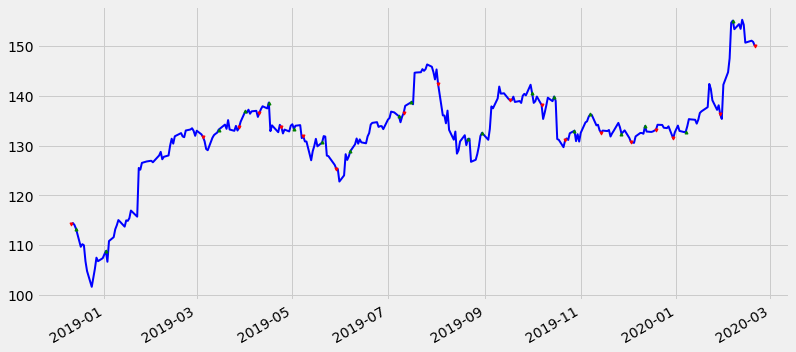

In [31]:
plt_data = data[-300:]
fig, ax1 = plt.subplots()
ax1.plot(plt_data['Adj Close'].index, plt_data['Adj Close'], 'b-', linewidth=2) 

# Plot the buy signals
ax1.plot(plt_data.loc[plt_data.labels == 1].index, 
         plt_data['Adj Close'][plt_data.labels == 1],
         '^', markersize=3, color='g')

# Plot the sell signals
ax1.plot(plt_data.loc[plt_data.labels == -1].index, 
         plt_data['Adj Close'][plt_data.labels == -1],
         'v', markersize=3, color='r')
fig.autofmt_xdate()


## Select Best Feature

In [0]:
def select_features(data, num_features=225, topK=350, start_col='Open', end_col='eom_26'):
    """
    num_features should be a perfect square
    """
    data_batch = data.copy()
    list_features = list(data_batch.loc[:, start_col:end_col].columns)
    mm_scaler = MinMaxScaler(feature_range=(0, 1))  # or StandardScaler?
    x_train = mm_scaler.fit_transform(data_batch.loc[:, start_col:end_col].values)
    y_train = data_batch['labels'].values
    
    select_k_best = SelectKBest(f_classif, k=topK)
    select_k_best.fit(x_train, y_train)
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

    select_k_best = SelectKBest(mutual_info_classif, k=topK)
    select_k_best.fit(x_train, y_train)
    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

    common = list(set(selected_features_anova).intersection(selected_features_mic))
    if len(common) < num_features:
        raise Exception(
            'number of common features found {} < {} required features. Increase "topK"'.format(len(common), num_features))
                 
    printable_features = "\n".join(["\t".join(common[i:i + 10]) for i in range(0, len(common), 10)])

    print("common selected featues:\n{}".format(printable_features))
                                                                             
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:num_features])
    return feat_idx
 

In [51]:
feature_idx = select_features(data)

common selected featues:
ema_10	fi_17	cci_7	dpo_9	Close_sma_16	dpo_24	trix_23	bb_7	roc_24	cmo_18
bb_15	cmo_7	Close_sma_18	fi_14	dpo_11	cci_20	trix_22	bb_6	cmf_6	fi_19
dmi_7	fi_23	ema_26	wr_26	cmo_6	rsi_24	mfi_6	Close_sma_14	Open_sma_13	trix_21
trix_25	dmi_11	Open_sma_10	ema_7	trix_14	roc_22	cci_19	kst_26	cci_11	Open_sma_18
bb_18	kst_8	ema_8	bb_22	trix_16	Close_sma_12	Close_sma_21	dmi_19	roc_8	dpo_17
cci_18	dpo_10	cmf_10	cmo_21	ema_24	cci_13	cci_15	dmi_23	cci_22	cmf_8
wma_6	roc_6	wr_21	fi_11	dpo_22	kst_10	Close_sma_11	dmi_8	dmi_18	fi_15
eom_7	Open_sma_14	trix_20	cci_14	cmo_8	dmi_15	roc_13	rsi_20	roc_10	dpo_6
dpo_19	cmo_12	wma_18	cmf_23	dmi_12	rsi_8	rsi_10	cci_6	cci_9	wr_23
kst_16	kst_22	bb_11	bb_16	rsi_14	cmo_10	ema_6	wma_12	cmf_12	rsi_12
wr_19	rsi_19	wr_24	rsi_11	cmf_7	Close_sma_13	Open_sma_8	wma_9	cmf_15	wr_10
kst_9	wma_8	kst_11	dpo_23	fi_10	cci_12	eom_8	wma_24	wr_16	cmo_17
kst_7	ema_14	dmi_22	cmf_21	ema_16	rsi_21	bb_12	mfi_14	mfi_7	bb_14
ema_22	Close_sma_22	Open_sma_19	trix_26	trix_1

## Create Model

### Create Metrics

In [0]:
 def get_precision(i, conf_mat):
    print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
    precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
    recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
    tf.add(i, 1)
    return i, conf_mat, precision, recall

def tf_count(i):
    elements_equal_to_value = tf.equal(y_true_class, i)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    class_counts[i].assign(count)
    tf.add(i, 1)
    return count

def condition(i, conf_mat):
    return tf.less(i, 3)

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(tf.math.multiply(f1s, weights))
    return weighted_f1

def calculate_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def calculate_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall
    """

    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


### Create CNN Model

In [0]:
get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})

params = {'batch_size': 60, 
          'conv2d_layers': {'conv2d_do_1': 0.0, 
                            'conv2d_filters_1': 30,
                            'conv2d_kernel_size_1': 2, 
                            'conv2d_mp_1': 2, 
                            'conv2d_strides_1': 1,
                            'kernel_regularizer_1':0.0, 
                            'conv2d_do_2': 0.01, 
                            'conv2d_filters_2': 10,
                            'conv2d_kernel_size_2': 2, 
                            'conv2d_mp_2': 2, 
                            'conv2d_strides_2': 2,
                            'kernel_regularizer_2':0.0, 
                            'layers': 'two'},
          'dense_layers': {'dense_do_1': 0.07, 
                            'dense_nodes_1': 100, 
                            'kernel_regularizer_1':0.0, 
                            'layers': 'one'},
          'epochs': 3000, 
          'lr': 0.001, 
          'optimizer': 'adam', 
          'input_dim_1': 15, 
          'input_dim_2': 15, 
          'input_dim_3': 3}

In [0]:
def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    # (batch_size, timesteps, data_dim)
    # x_train, y_train = get_data_cnn(df, df.head(1).iloc[0]["timestamp"])[0:2]
    conv2d_layer1 = Conv2D(params["conv2d_layers"]["conv2d_filters_1"],
                           params["conv2d_layers"]["conv2d_kernel_size_1"],
                           strides=params["conv2d_layers"]["conv2d_strides_1"],
                           kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_1"]),
                           padding='valid', activation="relu", use_bias=True,
                           kernel_initializer='glorot_uniform',
                           input_shape=(params['input_dim_1'],
                                        params['input_dim_2'], params['input_dim_3']))
    model.add(conv2d_layer1)

    if params["conv2d_layers"]['conv2d_mp_1'] == 1:
        model.add(MaxPool2D(pool_size=2))

    model.add(Dropout(params['conv2d_layers']['conv2d_do_1']))

    if params["conv2d_layers"]['layers'] == 'two':
        conv2d_layer2 = Conv2D(params["conv2d_layers"]["conv2d_filters_2"],
                               params["conv2d_layers"]["conv2d_kernel_size_2"],
                               strides=params["conv2d_layers"]["conv2d_strides_2"],
                               kernel_regularizer=regularizers.l2(params["conv2d_layers"]["kernel_regularizer_2"]),
                               padding='valid', activation="relu", use_bias=True,
                               kernel_initializer='glorot_uniform')
        model.add(conv2d_layer2)
        if params["conv2d_layers"]['conv2d_mp_2'] == 1:
            model.add(MaxPool2D(pool_size=2))
        model.add(Dropout(params['conv2d_layers']['conv2d_do_2']))

    model.add(Flatten())

    model.add(Dense(params['dense_layers']["dense_nodes_1"], activation='relu'))

    model.add(Dropout(params['dense_layers']['dense_do_1']))

    if params['dense_layers']["layers"] == 'two':
        model.add(Dense(params['dense_layers']["dense_nodes_2"], activation='relu',
                        kernel_regularizer=params['dense_layers']["kernel_regularizer_1"]))
        model.add(Dropout(params['dense_layers']['dense_do_2']))

    model.add(Dense(3, activation='softmax'))

    if params["optimizer"] == 'rmsprop':
        optimizer = optimizers.RMSprop(lr=params["lr"])
    elif params["optimizer"] == 'sgd':
        optimizer = optimizers.SGD(lr=params["lr"], decay=1e-6, momentum=0.9, nesterov=True)
    elif params["optimizer"] == 'adam':
        optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
    # from keras.utils.vis_utils import plot_model use this too for diagram with plot
    model.summary(print_fn=lambda x: print(x + '\n'))
    return model


In [64]:
model = create_model_cnn(params)
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1,
                   patience=100, 
                   min_delta=0.0001)
rlp = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.02, 
                        patience=10, 
                        verbose=1, 
                        mode='min',
                        min_delta=0.001, 
                        cooldown=1, 
                        min_lr=0.0001)

Training with params {'batch_size': 60, 'conv2d_layers': {'conv2d_do_1': 0.0, 'conv2d_filters_1': 30, 'conv2d_kernel_size_1': 2, 'conv2d_mp_1': 2, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.01, 'conv2d_filters_2': 10, 'conv2d_kernel_size_2': 2, 'conv2d_mp_2': 2, 'conv2d_strides_2': 2, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.07, 'dense_nodes_1': 100, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam', 'input_dim_1': 15, 'input_dim_2': 15, 'input_dim_3': 3}
Model: "sequential_2"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_4 (Conv2D)            (None, 14, 14, 30)        390       

_________________________________________________________________

dropout_6 (Dropout)          (None, 14, 14, 30)        0         

_________________________________________________________________

con

## Train Model

In [0]:
def plot_history(history, count):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['f1_metric'])
    plt.plot(history.history['val_f1_metric'])
    plt.title('Model Metrics')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(
        ['train_loss', 'val_loss', 'train_acc', 'val_acc', 'f1', 'val_f1'], 
        loc='upper left')

In [0]:
def train_model(model):
    count = 0
    is_last_batch = False
    while !is_last_batch:
        print("training for batch number {}".format(count))
        x_train, y_train, x_cv, y_cv, x_test, y_test, df_batch_train,\
        df_batch_test, sample_weights, is_last_batch = \
        get_rolling_data_next(None, 12)

        history = model.fit(x_train, y_train, epochs=params['epochs'], verbose=0,
                            batch_size=64, shuffle=True,
                            validation_data=(x_cv, y_cv),
                            callbacks=[es, None, rlp], 
                            sample_weight=sample_weights)

        count = count + 1
        plot_history(history, count)
        min_arg = np.argmin(np.array(history.history['val_loss']))
        print("Best val_loss is {} and corresponding train_loss is {}".format(
            history.history['val_loss'][min_arg], history.history['loss'][min_arg]))
        test_res = model.evaluate(x_test, y_test, verbose=0)
        print("keras evaluate result = " + str(test_res) + 
              ", metrics=" + str(model.metrics_names))
        
        pred = model.predict(x_test)
        check_baseline(np.argmax(pred, axis=1), np.argmax(y_test, axis=1))
        conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
        print('\n'+str(conf_mat))
        labels = [0, 1, 2]
        f1_weighted = f1_score(np.argmax(y_test, axis=1), 
                               np.argmax(pred, axis=1), 
                               labels=None,
                               average='weighted', 
                               sample_weight=None)
        print("F1 score (weighted) " + str(f1_weighted))
        print("F1 score (macro) " + str(
                f1_score(np.argmax(y_test, axis=1), 
                         np.argmax(pred, axis=1), 
                         labels=None,
                         average='macro', 
                         sample_weight=None)))
        for i, row in enumerate(conf_mat):
            print("precision of class {} = {}".format(i, np.round(row[i] / np.sum(row), 2)))
